In [5]:
# Step 1: Install bing-image-downloader
!pip install bing-image-downloader pillow

# Step 2: Import
from bing_image_downloader import downloader
import os
from PIL import Image

# Step 3: Download 100 images of dogs
downloader.download("dog", limit=100, output_dir='dog_dataset', adult_filter_off=True, force_replace=False, timeout=60)

# Step 4: Resize images to 512x512
output_folder = "dog_dataset/dog"
for filename in os.listdir(output_folder):
    file_path = os.path.join(output_folder, filename)
    try:
        img = Image.open(file_path).convert("RGB")
        img = img.resize((512, 512))
        img.save(file_path)
    except:
        os.remove(file_path)  # remove corrupted files

print("✅ Done! All resized dog images are saved in 'dog_dataset/dog' folder.")


[%] Downloading Images to /content/dog_dataset/dog


[!!]Indexing page: 1

[%] Indexed 49 Images on Page 1.


[%] Downloading Image #1 from https://w-dog.org/android-wallpapers/16/17/478857865223221/dog-puppy-portrait.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://alchetron.com/cdn/dog-7d616eb5-a01e-45f7-8b59-31fd465a0ef-resize-750.jpeg
[%] File Downloaded !

[%] Downloading Image #3 from https://site-547756.mozfiles.com/files/547756/medium/Dog2.jpg
[%] File Downloaded !

[%] Downloading Image #4 from http://2.bp.blogspot.com/-eeEC-mhppY8/UPkMjuPcpOI/AAAAAAAAGok/dM8CU0zSD1A/s1600/Beautiful+dog+hd+Wallpapers.jpg
[%] File Downloaded !

[%] Downloading Image #5 from http://bebusinessed.com/wp-content/uploads/2014/03/734899052_13956580111.jpg
[%] File Downloaded !

[%] Downloading Image #6 from http://eskipaper.com/images/dogs-20.jpg
[%] File Downloaded !

[%] Downloading Image #7 from http://wallpapercave.com/wp/EtRor5S.jpg
[%] File Downloaded !

[%] Downloading Image #8

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


✅ Done! All resized dog images are saved in 'dog_dataset/dog' folder.


In [46]:
!pip install accelerate transformers diffusers==0.30.0 safetensors datasets torch torchvision peft pillow


In [47]:
import os, json

image_folder = "dog_dataset/dog"
metadata_path = os.path.join(image_folder, "metadata.jsonl")

with open(metadata_path, "w") as f:
    for file in os.listdir(image_folder):
        if file.lower().endswith((".png", ".jpg", ".jpeg")):
            entry = {"file_name": file, "text": "a photo of a dog"}
            f.write(json.dumps(entry) + "\n")

print("✅ metadata.jsonl created at:", metadata_path)


✅ metadata.jsonl created at: dog_dataset/dog/metadata.jsonl


In [48]:
from datasets import load_dataset

dataset = load_dataset(
    "imagefolder",
    data_dir="dog_dataset",
    split="train"
)

print(dataset)



Resolving data files:   0%|          | 0/111 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['image', 'text'],
    num_rows: 108
})


In [49]:
from torchvision import transforms
from transformers import CLIPTokenizer
import torch

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

image_transforms = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

def preprocess(example):
    img = example["image"]
    if not isinstance(img, torch.Tensor):
        img = image_transforms(img)
    # Stable Diffusion needs 4 channels
    if img.shape[0] == 3:
        alpha = torch.ones(1, img.shape[1], img.shape[2])
        img = torch.cat([img, alpha], dim=0)
    example["pixel_values"] = img

    tokens = tokenizer(
        example["text"],
        padding="max_length",
        truncation=True,
        max_length=tokenizer.model_max_length,
        return_tensors="pt"
    )
    example["input_ids"] = tokens.input_ids.squeeze(0)
    return example

dataset = dataset.map(preprocess)
print("✅ Preprocessing complete!")


Map:   0%|          | 0/108 [00:00<?, ? examples/s]

✅ Preprocessing complete!


In [50]:
dataset.save_to_disk("dog_dataset_hf")
print("✅ Dataset saved at dog_dataset_hf")


Saving the dataset (0/1 shards):   0%|          | 0/108 [00:00<?, ? examples/s]

✅ Dataset saved at dog_dataset_hf


In [51]:
from datasets import load_from_disk

dataset = load_from_disk("dog_dataset_hf")
print(f"✅ Dataset loaded with {len(dataset)} images")


✅ Dataset loaded with 108 images


In [52]:
from diffusers import DDPMScheduler, UNet2DConditionModel
from transformers import CLIPTextModel
from peft import LoraConfig, get_peft_model

model_id = "stabilityai/stable-diffusion-2-1-base"

text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder")
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet")
noise_scheduler = DDPMScheduler.from_pretrained(model_id, subfolder="scheduler")


In [53]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["to_q", "to_v"],
    lora_dropout=0.05,
    bias="none"
)
unet = get_peft_model(unet, lora_config)


In [65]:
from torch.utils.data import DataLoader
import torch

def collate_fn(batch):
    # Ensure pixel_values are tensors
    pixel_values = torch.stack([
        torch.tensor(item["pixel_values"]) if isinstance(item["pixel_values"], list) else item["pixel_values"]
        for item in batch
    ])

    # Ensure input_ids are tensors
    input_ids = torch.stack([
        torch.tensor(item["input_ids"]) if isinstance(item["input_ids"], list) else item["input_ids"]
        for item in batch
    ])

    return {"pixel_values": pixel_values, "input_ids": input_ids}

train_dataloader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)


In [66]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

unet.to(device)
text_encoder.to(device)

optimizer = torch.optim.AdamW(unet.parameters(), lr=1e-4)


Using device: cuda


In [80]:
# Set dataset format
dataset.set_format(type="torch", columns=["pixel_values", "input_ids"])
train_dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

for epoch in range(num_epochs):
    print(f"=== Epoch {epoch+1}/{num_epochs} ===")
    for batch in train_dataloader:
        pixel_values = batch["pixel_values"].to(device, dtype=torch.float16)
        input_ids = batch["input_ids"].to(device)

        noise = torch.randn_like(pixel_values)
        timesteps = torch.randint(
            0, noise_scheduler.num_train_timesteps,
            (pixel_values.shape[0],), device=device
        ).long()
        noisy_images = noise_scheduler.add_noise(pixel_values, noise, timesteps)

        with torch.autocast("cuda", dtype=torch.float16):
            # Freeze text encoder to save memory
            with torch.no_grad():
                encoder_hidden_states = text_encoder(input_ids).last_hidden_state
            noise_pred = unet(noisy_images, timesteps, encoder_hidden_states).sample
            loss = torch.nn.functional.mse_loss(noise_pred, noise)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

    print(f"Epoch {epoch+1} finished, loss: {loss.item():.4f}")


=== Epoch 1/3 ===
Epoch 1 finished, loss: 0.0085
=== Epoch 2/3 ===
Epoch 2 finished, loss: 0.0050
=== Epoch 3/3 ===
Epoch 3 finished, loss: 0.0035


In [81]:
# Save LoRA weights only
unet.save_pretrained("dog_unet_lora")
print("✅ LoRA weights saved at dog_unet_lora")


✅ LoRA weights saved at dog_unet_lora


In [82]:
text_encoder.save_pretrained("dog_text_encoder")
print("✅ Text encoder saved")


✅ Text encoder saved


In [84]:
from diffusers import StableDiffusionPipeline, DDPMScheduler, AutoencoderKL
from transformers import CLIPTokenizer, CLIPTextModel
from peft import PeftModel
import torch

device = "cuda"

# Base model
model_id = "stabilityai/stable-diffusion-2-1-base"

# Load tokenizer and text encoder
tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder")

# Load UNet
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet")
# Apply your trained LoRA weights
unet = PeftModel.from_pretrained(unet, "dog_unet_lora")

# Load VAE
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae")

# Scheduler
scheduler = DDPMScheduler.from_pretrained(model_id, subfolder="scheduler")

# Build pipeline
pipe = StableDiffusionPipeline(
    vae=vae,
    text_encoder=text_encoder,
    unet=unet,
    tokenizer=tokenizer,
    scheduler=scheduler,
    safety_checker=None,
    feature_extractor=None
).to(device)

# Generate an image
prompt = "A cute dog sitting in a garden, digital art"
image = pipe(prompt, height=128, width=128, num_inference_steps=25).images[0]

# Save it
image.save("dog_generated.png")
print("✅ Image saved as dog_generated.png")


config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/25 [00:00<?, ?it/s]

✅ Image saved as dog_generated.png


  0%|          | 0/25 [00:00<?, ?it/s]

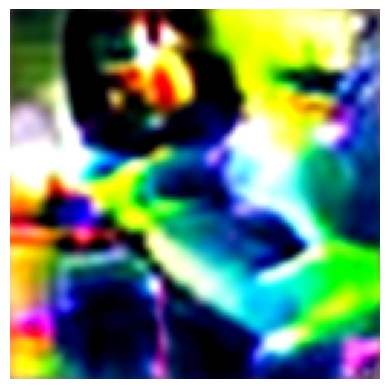

In [86]:
from PIL import Image
import matplotlib.pyplot as plt

# Prompt
prompt = "A cute dog sitting in a garden, digital art"

# Generate image
generated = pipe(prompt, height=128, width=128, num_inference_steps=25).images[0]

# Show in notebook
plt.imshow(generated)
plt.axis('off')
plt.show()


In [87]:
!pip install fastapi uvicorn pyngrok


In [90]:
!ngrok config add-authtoken 32UJcbLWmAx87AUqlh1kPdeUaHL_545osib8ktxoLFrnYFDDs


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [99]:
from fastapi import FastAPI
from pydantic import BaseModel
import torch, base64
from io import BytesIO
from diffusers import StableDiffusionPipeline, DDPMScheduler, AutoencoderKL, UNet2DConditionModel
from transformers import CLIPTokenizer, CLIPTextModel
from peft import PeftModel

device = "cuda" if torch.cuda.is_available() else "cpu"

# ----- Load model & your LoRA -----
model_id = "stabilityai/stable-diffusion-2-1-base"
tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder")
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet")
unet = PeftModel.from_pretrained(unet, "dog_unet_lora")      # <-- your LoRA weights
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae")
scheduler = DDPMScheduler.from_pretrained(model_id, subfolder="scheduler")

pipe = StableDiffusionPipeline(
    vae=vae,
    text_encoder=text_encoder,
    unet=unet,
    tokenizer=tokenizer,
    scheduler=scheduler,
    safety_checker=None,
    feature_extractor=None
).to(device)

# ----- FastAPI app -----
app = FastAPI()

class Prompt(BaseModel):
    prompt: str
    height: int = 256
    width: int = 256
    steps: int = 30

@app.post("/generate")
def generate_image(data: Prompt):
    image = pipe(
        data.prompt,
        height=data.height,
        width=data.width,
        num_inference_steps=data.steps
    ).images[0]
    buf = BytesIO()
    image.save(buf, format="PNG")
    b64 = base64.b64encode(buf.getvalue()).decode()
    return {"image": b64}


ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-14' coro=<Server.serve() done, defined at /usr/local/lib/python3.12/dist-packages/uvicorn/server.py:69> exception=KeyboardInterrupt()>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/main.py", line 580, in run
    server.run()
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/server.py", line 67, in run
    return asyncio.run(self.serve(sockets=sockets))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/nest_asyncio.py", line 30, in run
    return loop.run_until_complete(task)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/nest_asyncio.py", line 92, in run_until_complete
    self._run_once()
  File "/usr/local/lib/python3.12/dist-packages/nest_asyncio.py", line 133, in _run_once
    handle._run()
  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run
    s

In [100]:
from fastapi.middleware.cors import CORSMiddleware

app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],  # Or specify your frontend URL for better security
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

In [101]:
from pyngrok import ngrok
public_url = ngrok.connect(8000)
print("Public URL:", public_url)


Public URL: NgrokTunnel: "https://a9fd135a5c8f.ngrok-free.app" -> "http://localhost:8000"


In [ ]:
!pip install nest_asyncio
import nest_asyncio
nest_asyncio.apply()

import uvicorn
uvicorn.run(app, host="0.0.0.0", port=8000)


INFO:     Started server process [2258]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO:     103.132.151.119:0 - "GET /generate HTTP/1.1" 405 Method Not Allowed
INFO:     103.132.151.119:0 - "GET /favicon.ico HTTP/1.1" 404 Not Found
INFO:     103.132.151.119:0 - "OPTIONS /generate HTTP/1.1" 200 OK


  0%|          | 0/30 [00:00<?, ?it/s]

INFO:     103.132.151.119:0 - "POST /generate HTTP/1.1" 200 OK
